In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from keras.applications.resnet50 import ResNet50
import tensorflow as tf
from .preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras import Model
import gevent



AlreadyExistsError: Another metric with the same name already exists.

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [7]:

pip install keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = '../mycode/Data/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = '../mycode/Data/valid',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = '../mycode/Data/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)
base_model_2 = tf.keras.applications.ResNet101V2(input_shape=(224,224,3),include_top=False,weights="imagenet")
# Freezing Layers
for layer in base_model_2.layers:
    layer.trainable = False

Found 613 images belonging to 4 classes.
Found 69 images belonging to 4 classes.
Found 316 images belonging to 4 classes.


In [6]:
x = base_model_2.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation = "softmax")(x)
model = Model(inputs= base_model_2.input , outputs = x)

In [7]:
ACCURACY_THRESHOLD = 0.99

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]
callbacks = myCallback()
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

In [2]:
from keras.models import load_model

model.save('my_model.pkl')

NameError: name 'model' is not defined

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 300,callbacks=[callbacks],verbose = 1)

Epoch 1/300
10/10 [==============================] - 88s 7s/step - loss: 62.5437 - accuracy: 0.6803 - precision: 0.3596 - recall: 0.3573 - auc: 0.5828 - val_loss: 11.5417 - val_accuracy: 0.7574 - val_precision: 0.5147 - val_recall: 0.5147 - val_auc: 0.7351
Epoch 2/300
10/10 [==============================] - 58s 6s/step - loss: 10.9379 - accuracy: 0.7667 - precision: 0.5334 - recall: 0.5334 - auc: 0.7195 - val_loss: 3.1576 - val_accuracy: 0.7941 - val_precision: 0.5882 - val_recall: 0.5882 - val_auc: 0.7709
Epoch 3/300
10/10 [==============================] - 59s 6s/step - loss: 5.1673 - accuracy: 0.7855 - precision: 0.5714 - recall: 0.5677 - auc: 0.7524 - val_loss: 4.6383 - val_accuracy: 0.7132 - val_precision: 0.4265 - val_recall: 0.4265 - val_auc: 0.7084
Epoch 4/300
10/10 [==============================] - 57s 6s/step - loss: 2.3557 - accuracy: 0.8267 - precision: 0.6546 - recall: 0.6493 - auc: 0.8352 - val_loss: 1.4060 - val_accuracy: 0.7868 - val_precision: 0.5735 - val_recall: 0.

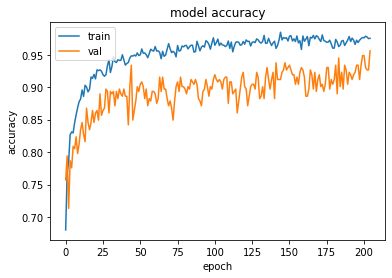

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("resnet_accuracy.png")
plt.show()

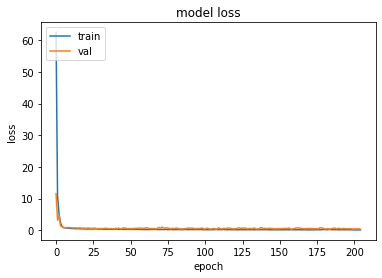

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("resnet_loss.png")
plt.show()

In [ ]:
def chestScanPrediction(path, _model):
    classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
    # Loading Image
    img = image.load_img(path, target_size=(224,224, 3))
    # Normalizing Image
    norm_img = image.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(_model.predict(input_arr_img))
    # Printing Model Prediction
    print(classes_dir[pred])

In [1]:
from tensorflow.keras.preprocessing import image
path = "../mycode/Data/test/large.cell.carcinoma/000110.png"
chestScanPrediction(path,model)

NameError: name 'chestScanPrediction' is not defined

In [ ]:
from tensorflow.keras.preprocessing import image
path = "../mycode/Data/test/squamous.cell.carcinoma/000145 (6).png"
chestScanPrediction(path,model)

1/1 [==============================] - 0s 148ms/step
Squamous cell carcinoma


In [ ]:
from tensorflow.keras.preprocessing import image
path = "../mycode/Data/test/normal/7 - Copy.png"
chestScanPrediction(path,model)

1/1 [==============================] - 0s 133ms/step
Normal


In [ ]:
from tensorflow.keras.preprocessing import image
path = "../mycode/Data/test/adenocarcinoma/000109 (2).png"
chestScanPrediction(path,model)

1/1 [==============================] - 0s 137ms/step
Adenocarcinoma


In [ ]:
result = model.evaluate(test_dataset, verbose=1)

5/5 [==============================] - 18s 3s/step - loss: 0.5769 - accuracy: 0.9206 - precision: 0.8435 - recall: 0.8381 - auc: 0.9595


In [1]:
path = "../mycode/Data/test/squamous.cell.carcinoma000169 (6).png"
chestScanPrediction(path,model)

NameError: name 'chestScanPrediction' is not defined

In [ ]:
model.summary()

NameError: name 'model' is not defined

In [1]:
import dash
from dash.dependencies import Input, Output, State
from dash import dcc
from dash import html
from dash import no_update
import base64
import io
from io import BytesIO
import re
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv3D, BatchNormalization, Activation
from keras import backend as K
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from keras.models import load_model
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc 
from dash.dependencies import Input, Output
import smtplib, ssl

ImportError: cannot import name 'BaseResponse' from 'werkzeug.wrappers' (C:\Users\shiwa\anaconda3\lib\site-packages\werkzeug\wrappers\__init__.py)

In [3]:
import dash
from dash.dependencies import Input, Output, State
from dash import dcc
from dash import html
from dash import no_update
import base64
import io
from io import BytesIO
import re
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv3D, BatchNormalization, Activation
from keras import backend as K
import os
from PIL import Image, ImageFile
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from keras.models import load_model
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc 
from dash.dependencies import Input, Output
import smtplib, ssl
from skimage.transform import resize


classes = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

enc = OneHotEncoder()
enc.fit([[0], [1], [2], [3]]) 
def names(number):
    if(number == 0):
        return 'a adenocarcinoma'
    elif(number == 1):
        return 'a large.cell.carcinoma'
    elif(number == 2):
        return 'normal'
    elif(number == 3):
        return 'a squamous.cell.carcinoma'  
   

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

server = app.server




   


app.layout = html.Div([
   

    html.H1(children='Bharati Vidyapeeth College of Engineering, Pune', style={'textAlign': 'center', 'font-color': 'white',
                                                                               'background-color': '#4BC7AD'
        }),
    
     html.H2(children='lung Tumor Classifier - Get Yourself Diagnozed', style={'padding': '70px 60px 60px 70px', 'background-color': '#E1C89C', 'textAlign': 'center'} ),
    dcc.Markdown('''
                ###### Step 1: Import a single image using upload button
                ###### Step 2: Wait for prediction and interesting facts to appear
                ###### Step 3: Get yourself diagnozed.
    '''),
    
    
    dcc.Upload(
        id='upload-image',
        children=html.Div([
            'Drag and Drop or ',
            html.A('Select Files')
        ]),
        style={
            'width': '95%',
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '5px',
            'textAlign': 'center',
            'margin': '10px'
        }, 
        # Allow multiple files to be uploaded
        multiple=True
    ),
    html.Div(id='output-image-upload', style={'position':'absolute', 'left':'200px', 'top':'250px'}),
    
    html.Div(id='prediction', style={'position':'absolute', 'border':'2px solid black','left':'800px', 'top':'310px', 'margin-top':'280px', 'font-size':'x-large'}),
    html.Div(id='prediction2', style={'position':'absolute', 'left':'800px', 'top':'365px','margin-top':'320px', 'font-size': 'x-large'}),
    html.Div(id='facts', style={'position':'absolute','border':'2px solid black', 'left':'800px', 'top':'465px','margin-top':'330px', 'font-size': 'large',\
                               'height': '100px', 'width': '500px'}),
    

])



def parse_contents(contents):
    
    return html.Img(src=contents, style={'height':'450px', 'width':'450px', 'margin-top':'280px'})


@app.callback([Output('output-image-upload', 'children'), Output('prediction', 'children'), Output('prediction2', 'children'), 
              Output('facts', 'children')],
              [Input('upload-image', 'contents')])

def update_output(list_of_contents):        
    
    if list_of_contents is not None:
        children = parse_contents(list_of_contents[0]) 
         
        img_data = list_of_contents[0]
        img_data = re.sub('data:image/png;base64,', '', img_data)
        img_data = base64.b64decode(img_data + "==")  
        
        stream = io.BytesIO(img_data)
        img_pil = Image.open(stream)
        
        
        #Load model, change image to array and predict
        model = load_model('my_model.h5') 
        dim = (200, 200)
        
        
        img = np.array(img_pil.resize(dim))
        
        x = img.reshape(1,200,200,3)

        answ = model.predict(x)
        classification = np.where(answ == np.amax(answ))[1][0]
        pred=str(round(answ[0][classification]*100 ,3)) + '% confidence there is ' + names(classification)   
        
        #Second prediction and facts about tumor if there is
        if classification==0:
            facts = 'Glioma is a type of tumor that occurs in the brain and spinal cord.\
                    A glioma can affect your brain function and be life-threatening depending on\
                    its location and rate of growth.'
            no_tumor = str(round(answ[0][2]*100 ,3))
            pred2 = no_tumor + '% confidence there is no tumor'
            
        elif classification==1:
            facts = 'A meningioma is a tumor that arises from the meninges, the membranes that surround your brain.\
                    Most meningiomas grow very slowly, often over many years without causing symptoms.'
            no_tumor = str(round(answ[0][2]*100 ,3))
            pred2 = no_tumor + '% confidence there is no tumor'
        
        elif classification==3:
            facts = 'Pituitary tumors are abnormal growths that develop in your pituitary gland.\
                    Most pituitary tumors are noncancerous (benign) growths that remain in your pituitary\
                    gland or surrounding tissues.'
            no_tumor = str(round(answ[0][2]*100 ,3))
            pred2 = no_tumor + '% confidence there is no tumor'
        
        else:
            facts=None
            pred2 = None
        
        return children, pred, pred2, facts
    
    else:
        return (no_update, no_update, no_update, no_update)  

if __name__ == '__main__':
    app.run_server(debug=False)

ImportError: cannot import name 'BaseResponse' from 'werkzeug.wrappers' (C:\Users\shiwa\anaconda3\lib\site-packages\werkzeug\wrappers\__init__.py)

In [6]:
from PIL import Image


# sample.png is the name of the image
# file and assuming that it is uploaded
# in the current directory or we need
# to give the path
image = Image.open('test data/adenocarcinoma-left-lower-lobe.jpeg')
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)


JPEG
(315, 245)
L


In [3]:
import ipywidgets as widgets 
import cv2

In [4]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='adenocarcinoma'
    elif p==1:
        p='large.cell.carcinoma'
    elif p==2:
        print('The model predicts that there is no tumor')
    else:
        p='a squamous.cell.carcinoma'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [5]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [3]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install ipywidgets


     -------------------------------------- 123.4/123.4 kB 1.0 MB/s eta 0:00:00
     -------------------------------------- 245.3/245.3 kB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 4.1 MB/s eta 0:00:00
  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl (26 kB)
     ---------------------------------------- 9.9/9.9 MB 5.6 MB/s eta 0:00:00
  Using cached Send2Trash-1.8.0-py3-none-any.whl (18 kB)
     ---------------------------------------- 73.3/73.3 kB 4.2 MB/s eta 0:00:00
  Using cached argon2_cffi-21.3.0-py3-none-any.whl (14 kB)
     ---------------------------------------- 59.5/59.5 kB 3.3 MB/s eta 0:00:00
     -------------------------------------- 561.6/561.6 kB 3.9 MB/s eta 0:00:00
     -------------------------------------- 160.9/160.9 kB 3.2 MB/s eta 0:00:00
     -------------------------------------- 128.2/128.2 kB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 71.8/71.8 kB ? eta 0:00:00
  Using cached mistune-0.8.4